## Meteo computations

In this notebook you will:

In [10]:
import earthkit.data as ekd
import earthkit.meteo as ekm 

ds = ekd.from_source("sample", "tuv_pl_2x2.grib")

tuv_pl_2x2.grib:   0%|          | 0.00/578k [00:00<?, ?B/s]

#### Earthkit-meteo

You can do meteorological computations with ``earthkit-meteo``. It is still work in progress and at the moment it can only take array input  (numpy, torch or CuPy) and generate array output. Computations with GRIB data is still possible but you need to use a lower level API. 

#### Compute potential temperature

In this exercise you will compute the potential temperature from temperature.

First, filter the temperature fields from the input data.

In [11]:
t = ds.sel(param="t")
t.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,t,isobaricInhPa,1000,20180801,1200,0,an,0,regular_ll
1,ecmf,t,isobaricInhPa,850,20180801,1200,0,an,0,regular_ll
2,ecmf,t,isobaricInhPa,700,20180801,1200,0,an,0,regular_ll
3,ecmf,t,isobaricInhPa,500,20180801,1200,0,an,0,regular_ll
4,ecmf,t,isobaricInhPa,400,20180801,1200,0,an,0,regular_ll
5,ecmf,t,isobaricInhPa,300,20180801,1200,0,an,0,regular_ll


Next, use the method. The computation needs to be executed in a loop on all the fields. 

In [33]:
from earthkit.meteo import thermo 
from earthkit.data import FieldList

res = []

# loop and perform the computation per field
for f in t:
    pres_pa = f.metadata("level") * 100
    t_vals = f.values
    
    # do the computation
    pt_vals = thermo.potential_temperature(t_vals, pres_pa)
    print(f"t_mean={t_vals.mean():.2f} p={pres_pa} pt_mean={pt_vals.mean():.2f}")

    # encode a new GRIB field (in memory)
    f_new = f.copy(values=pt_vals, metadata=f.metadata().override(shortName="pt"))
    
    res.append(f_new)

# create the resulting fieldlist    
ds_pt = FieldList.from_fields(res)

t_mean=283.60 p=100000 pt_mean=283.60
t_mean=277.18 p=85000 pt_mean=290.35
t_mean=269.78 p=70000 pt_mean=298.72
t_mean=255.20 p=50000 pt_mean=311.09
t_mean=244.23 p=40000 pt_mean=317.31
t_mean=230.08 p=30000 pt_mean=324.54


Check the resulting fieldlist.

In [34]:
ds_pt.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,pt,isobaricInhPa,1000,20180801,1200,0,an,0,regular_ll
1,ecmf,pt,isobaricInhPa,850,20180801,1200,0,an,0,regular_ll
2,ecmf,pt,isobaricInhPa,700,20180801,1200,0,an,0,regular_ll
3,ecmf,pt,isobaricInhPa,500,20180801,1200,0,an,0,regular_ll
4,ecmf,pt,isobaricInhPa,400,20180801,1200,0,an,0,regular_ll
5,ecmf,pt,isobaricInhPa,300,20180801,1200,0,an,0,regular_ll


Please note that this data is stored in memory. You can save it into a file if needed.

In [35]:
ds_pt.to_target("file", "_pt_res.grib")

Plot the resulting 850 hPa potential temperature field.

ECCODES WARNING :  Key gridSpec is not yet implemented. Work in progress...


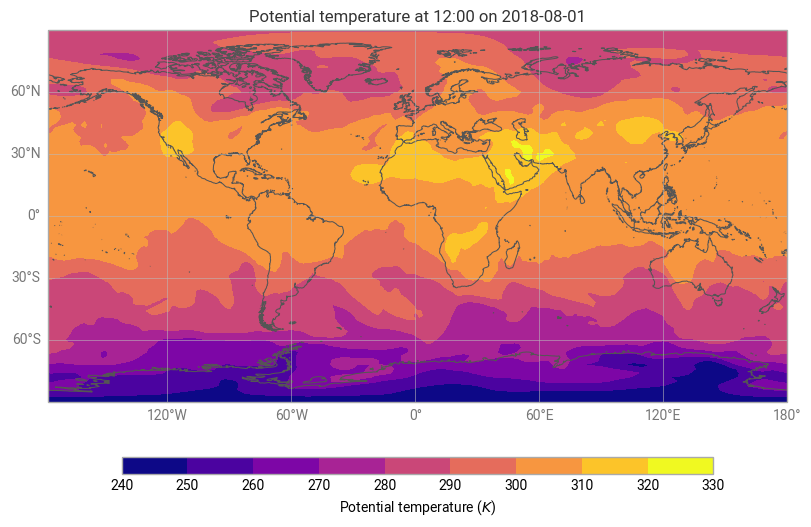

In [36]:
import earthkit.plots as ekp
ekp.quickplot(ds_pt[1]).show()

In [28]:
ds_pt[1].metadata("shortName")

'pt'

In [7]:
t_xr = t.to_xarray()
t_xr

<xarray.Dataset> Size: 4kB
Dimensions:    (level: 6, latitude: 7, longitude: 12)
Coordinates:
  * level      (level) int64 48B 300 400 500 700 850 1000
  * latitude   (latitude) float64 56B 90.0 60.0 30.0 0.0 -30.0 -60.0 -90.0
  * longitude  (longitude) float64 96B 0.0 30.0 60.0 90.0 ... 270.0 300.0 330.0
Data variables:
    t          (level, latitude, longitude) float64 4kB ...
Attributes: (12/13)
    param:        t
    paramId:      130
    class:        od
    stream:       oper
    levtype:      pl
    type:         an
    ...           ...
    date:         20180801
    time:         1200
    domain:       g
    number:       0
    Conventions:  CF-1.8
    institution:  ECMWF